# Deterministic Goldstein-Taylor equation
---
Consider the equation
$$
\left\{
\begin{aligned}
&\frac{\partial u}{\partial t} + \frac{\partial v}{\partial x} = 0, \\
&\frac{\partial v}{\partial t} + \frac{1}{\epsilon}\frac{\partial u}{\partial x} = - \frac{1}{\epsilon}v, 
\end{aligned}
\right.
$$
where $\epsilon$ is a small number.

The initial data are
$$
\left\{
\begin{aligned}
&u(x, 0) = 2, v(x, 0) = 0, x\in [-1, 0], \\
&u(x, 0) = 1, v(x, 0) = 0, x\in (0, 1],
\end{aligned}
\right.
$$

BC:
$$
u(-1, t) = 2, \ v(-1, t) = 0, \ u(1, t) = 1, \ v(1, t) = 0.
$$

The spatiotemporal domain is 
$$
(x, t) \in [-1, 1]\times [0, 0.25].
$$

In [1]:
NAME = "3_1e-12_3"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [2] + [64]*4 + [2] # (x, t) -> (u, v)
c0 = 6.0
w0 = jnp.array([[30.0, 30.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_u, w_v)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[-1., 0.], [1., 0.25]])
spatial_width = domain[1, 0]-domain[0, 0]

epsilon = 1e-12

@jax.jit
def model(params, xt): # for predictions
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

# @jax.jit
# def model_(params, xt): # for derivatives
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

# static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

# jacobian[i] = [[du/dx, du/dt],
#                [dv/dx, dv/dt]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
	
	if collocation[0] is not None:
		uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
		u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
		duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
		du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
		du_dx_c, dv_dx_c = duv_dxt_c[:, 0:1, 0], duv_dxt_c[:, 1:2, 0]
		loss_c1 = metaloss(du_dt_c + dv_dx_c, 0)
		loss_c2 = metaloss(dv_dt_c + 1/epsilon*du_dx_c, -1/epsilon*v_c)
# 		loss_c = loss_c1 + loss_c2
	else:
		loss_c1 = loss_c2 = 0
# 		loss_c = 0.0
        
	if dirichlet[0] is not None:
		uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
		u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
		loss_d1 = metaloss(u_d, dirichlet.u)
		loss_d2 = metaloss(v_d, dirichlet.v)
		loss_d = loss_d1 + loss_d2
	else:
		loss_d = 0.0

	return loss_c1, loss_c2, loss_d

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d = loss_fn_(params, batch)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d + l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d, loss_c1, loss_c2, loss_d, l1, l2

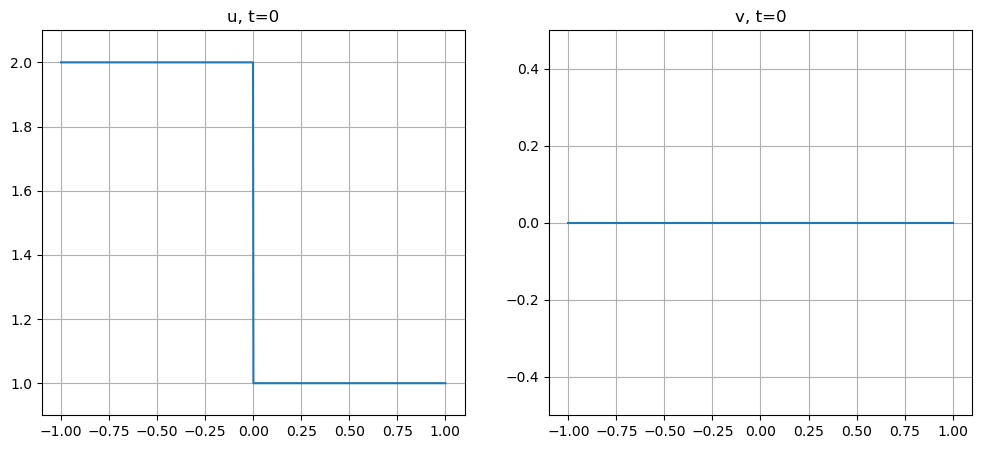

In [5]:
u0_fn = lambda x, t: jnp.select([x <= 0, x > 0], [2.0, 1.0])
v0_fn = lambda x, t: jnp.zeros_like(x)

u0_fn_ = lambda xt: jnp.select([xt[0] < 0, xt[0] > 0], [2.0, 1.0])
v0_fn_ = lambda xt: jnp.zeros_like(xt[0])

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([0.9, 2.1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-0.5, 0.5])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 2000
x_i = jnp.linspace(*domain[:, 0], n_i).reshape((-1, 1))
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_b = 2000
x_bl = jnp.ones((n_b, 1))*domain[0, 0]
x_br = jnp.ones((n_b, 1))*domain[1, 0]
t_b = jnp.linspace(*domain[:, 1], n_b).reshape((-1, 1))
x_b = jnp.vstack([x_bl, x_br])
t_b = jnp.vstack([t_b, t_b])
u_b = u0_fn(x_b, t_b)
v_b = v0_fn(x_b, t_b)

n_cx = 500
n_ct = 500
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
xt_c = tensor_grid([x_c, t_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])

dirichlet = dataset_Dirichlet(jnp.vstack([x_i, x_b]), jnp.vstack([t_i, t_b]), jnp.vstack([u_i, u_b]), jnp.vstack([v_i, v_b]))
collocation = dataset_Collocation(xt_c[:, 0:1], xt_c[:, 1:2])

In [6]:
# class Time_Marching_Generator:
# 	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every, count1 = 0):
# 		self.key = key
# 		self.spatial_points = spatial_points
# 		self.domain = temporal_domain
# 		self.batch_size = batch_size
# 		self.iterations = iterations
# 		self._count1 = count1
# 		self._count2 = update_every
# 		if count1 < iterations:
# 			self._update(self.domain[0])
# 		else:
# 			self._update(self.domain[1])
# 		self.update_every = update_every
		
# 	def _update(self, tmax):
# 		self.key, subkey = random.split(self.key)
# 		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
# 	def __iter__(self):
# 		return self
	
# 	def __next__(self):
# 		if self._count2 == self.update_every:
# 			self._count1 = max(self.iterations, self._count1 + 1)
# 			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
# 			self._update(tmax)
# 			self._count2 = 0
# 		else:
# 			self._count2 += 1
# 		return self.spatial_points, self._t

In [7]:
lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 1000, "collocation": 2000}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])

start_iteration = 0
iterations = 3000000
print_every = 10000
save_every = 100000
weights = {"c1": 1.0, "c2": epsilon, "d": 100.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/23, 00:47:44, Iteration: 0, Train Loss: 3.0524e+02, c1: 4.4354e+01, c2: 3.3509e+13, d: 2.2738e+00, l1_reg: 5.2839e+03, l2_reg: 1.2184e+05
2020/08/23, 00:48:50, Iteration: 10000, Train Loss: 2.0120e+00, c1: 2.7999e-01, c2: 5.8903e+11, d: 1.1429e-02, l1_reg: 5.0345e+03, l2_reg: 1.2124e+05
2020/08/23, 00:49:57, Iteration: 20000, Train Loss: 1.1563e+00, c1: 1.3055e-01, c2: 5.0221e+11, d: 5.2353e-03, l1_reg: 4.9901e+03, l2_reg: 1.2097e+05
2020/08/23, 00:51:03, Iteration: 30000, Train Loss: 1.0454e+00, c1: 9.9629e-02, c2: 4.7999e+11, d: 4.6575e-03, l1_reg: 4.9547e+03, l2_reg: 1.2073e+05
2020/08/23, 00:52:09, Iteration: 40000, Train Loss: 9.0679e-01, c1: 8.1153e-02, c2: 4.2978e+11, d: 3.9586e-03, l1_reg: 4.9243e+03, l2_reg: 1.2052e+05
2020/08/23, 00:53:15, Iteration: 50000, Train Loss: 8.7092e-01, c1: 8.4322e-02, c2: 3.1078e+11, d: 4.7581e-03, l1_reg: 4.8976e+03, l2_reg: 1.2026e+05
2020/08/23, 00:54:21, Iteration: 60000, Train Loss: 5.6359e-01, c1: 7.5797e-02, c2: 2.1993e+11, d: 2.678

2020/08/23, 01:48:29, Iteration: 550000, Train Loss: 1.6670e-01, c1: 2.6274e-02, c2: 1.8419e+10, d: 1.2201e-03, l1_reg: 4.2442e+03, l2_reg: 1.0919e+05
2020/08/23, 01:49:36, Iteration: 560000, Train Loss: 1.2178e-01, c1: 3.0340e-02, c2: 2.2089e+10, d: 6.9351e-04, l1_reg: 4.2421e+03, l2_reg: 1.0919e+05
2020/08/23, 01:50:42, Iteration: 570000, Train Loss: 1.6560e-01, c1: 2.6304e-02, c2: 1.5572e+10, d: 1.2373e-03, l1_reg: 4.2441e+03, l2_reg: 1.0911e+05
2020/08/23, 01:51:49, Iteration: 580000, Train Loss: 1.5357e-01, c1: 2.6709e-02, c2: 1.7369e+10, d: 1.0949e-03, l1_reg: 4.2511e+03, l2_reg: 1.0904e+05
2020/08/23, 01:52:55, Iteration: 590000, Train Loss: 1.4169e-01, c1: 2.4552e-02, c2: 1.1064e+10, d: 1.0607e-03, l1_reg: 4.2516e+03, l2_reg: 1.0894e+05
2020/08/23, 01:54:01, Iteration: 600000, Train Loss: 1.7404e-01, c1: 2.6035e-02, c2: 1.9672e+10, d: 1.2834e-03, l1_reg: 4.2496e+03, l2_reg: 1.0882e+05
2020/08/23, 01:55:07, Iteration: 610000, Train Loss: 1.1373e-01, c1: 2.2633e-02, c2: 1.3724e+1

2020/08/23, 02:49:14, Iteration: 1100000, Train Loss: 7.0445e-02, c1: 2.2801e-03, c2: 6.9051e+09, d: 6.1260e-04, l1_reg: 4.2844e+03, l2_reg: 1.0294e+05
2020/08/23, 02:50:20, Iteration: 1110000, Train Loss: 9.6834e-02, c1: 4.0105e-03, c2: 1.1156e+10, d: 8.1667e-04, l1_reg: 4.2828e+03, l2_reg: 1.0285e+05
2020/08/23, 02:51:26, Iteration: 1120000, Train Loss: 9.1083e-02, c1: 2.4516e-03, c2: 9.5450e+09, d: 7.9087e-04, l1_reg: 4.2798e+03, l2_reg: 1.0275e+05
2020/08/23, 02:52:33, Iteration: 1130000, Train Loss: 8.5394e-02, c1: 1.9741e-03, c2: 6.1749e+09, d: 7.7244e-04, l1_reg: 4.2762e+03, l2_reg: 1.0267e+05
2020/08/23, 02:53:39, Iteration: 1140000, Train Loss: 1.2082e-01, c1: 2.2163e-03, c2: 6.8007e+09, d: 1.1180e-03, l1_reg: 4.2823e+03, l2_reg: 1.0261e+05
2020/08/23, 02:54:45, Iteration: 1150000, Train Loss: 6.7184e-02, c1: 1.8129e-03, c2: 6.4699e+09, d: 5.8901e-04, l1_reg: 4.2874e+03, l2_reg: 1.0254e+05
2020/08/23, 02:55:51, Iteration: 1160000, Train Loss: 9.8388e-02, c1: 3.1951e-03, c2: 1.

2020/08/23, 03:48:52, Iteration: 1640000, Train Loss: 4.5963e-02, c1: 2.2435e-03, c2: 8.0618e+09, d: 3.5658e-04, l1_reg: 4.2729e+03, l2_reg: 9.8543e+04
2020/08/23, 03:49:59, Iteration: 1650000, Train Loss: 3.3166e-02, c1: 1.0803e-03, c2: 3.2583e+09, d: 2.8827e-04, l1_reg: 4.2742e+03, l2_reg: 9.8453e+04
2020/08/23, 03:51:06, Iteration: 1660000, Train Loss: 2.6361e-02, c1: 1.1725e-03, c2: 3.6613e+09, d: 2.1528e-04, l1_reg: 4.2720e+03, l2_reg: 9.8373e+04
2020/08/23, 03:52:12, Iteration: 1670000, Train Loss: 3.2326e-02, c1: 2.4319e-03, c2: 6.0572e+09, d: 2.3837e-04, l1_reg: 4.2711e+03, l2_reg: 9.8294e+04
2020/08/23, 03:53:18, Iteration: 1680000, Train Loss: 5.3906e-02, c1: 1.8701e-03, c2: 5.9657e+09, d: 4.6070e-04, l1_reg: 4.2697e+03, l2_reg: 9.8205e+04
2020/08/23, 03:54:25, Iteration: 1690000, Train Loss: 5.5842e-02, c1: 1.2205e-03, c2: 3.6757e+09, d: 5.0946e-04, l1_reg: 4.2971e+03, l2_reg: 9.8221e+04
2020/08/23, 03:55:30, Iteration: 1700000, Train Loss: 6.6545e-02, c1: 3.4510e-03, c2: 5.

2020/08/23, 04:48:30, Iteration: 2180000, Train Loss: 5.3405e-02, c1: 7.9285e-04, c2: 1.6156e+09, d: 5.0997e-04, l1_reg: 4.2596e+03, l2_reg: 9.5156e+04
2020/08/23, 04:49:36, Iteration: 2190000, Train Loss: 5.4558e-02, c1: 3.4055e-03, c2: 7.1562e+09, d: 4.3996e-04, l1_reg: 4.2607e+03, l2_reg: 9.5087e+04
2020/08/23, 04:50:42, Iteration: 2200000, Train Loss: 3.2689e-02, c1: 5.5171e-04, c2: 1.3069e+09, d: 3.0831e-04, l1_reg: 4.2541e+03, l2_reg: 9.5017e+04
2020/08/23, 04:51:49, Iteration: 2210000, Train Loss: 5.7335e-02, c1: 4.4691e-03, c2: 4.1784e+09, d: 4.8688e-04, l1_reg: 4.2597e+03, l2_reg: 9.4951e+04
2020/08/23, 04:52:55, Iteration: 2220000, Train Loss: 1.3706e-02, c1: 1.4520e-03, c2: 2.5126e+09, d: 9.7415e-05, l1_reg: 4.2537e+03, l2_reg: 9.4884e+04
2020/08/23, 04:54:02, Iteration: 2230000, Train Loss: 3.6991e-02, c1: 9.7366e-04, c2: 2.5657e+09, d: 3.3452e-04, l1_reg: 4.2513e+03, l2_reg: 9.4817e+04
2020/08/23, 04:55:08, Iteration: 2240000, Train Loss: 8.6501e-02, c1: 4.9398e-04, c2: 1.

2020/08/23, 05:48:06, Iteration: 2720000, Train Loss: 2.5837e-02, c1: 1.0751e-03, c2: 2.7579e+09, d: 2.2004e-04, l1_reg: 4.2351e+03, l2_reg: 9.1875e+04
2020/08/23, 05:49:12, Iteration: 2730000, Train Loss: 5.3323e-02, c1: 4.9474e-04, c2: 1.8011e+09, d: 5.1027e-04, l1_reg: 4.2295e+03, l2_reg: 9.1804e+04
2020/08/23, 05:50:18, Iteration: 2740000, Train Loss: 5.5751e-02, c1: 1.3193e-03, c2: 3.4854e+09, d: 5.0946e-04, l1_reg: 4.2321e+03, l2_reg: 9.1732e+04
2020/08/23, 05:51:24, Iteration: 2750000, Train Loss: 5.5287e-02, c1: 7.6015e-04, c2: 2.1337e+09, d: 5.2393e-04, l1_reg: 4.2284e+03, l2_reg: 9.1667e+04
2020/08/23, 05:52:31, Iteration: 2760000, Train Loss: 5.0578e-02, c1: 1.1261e-03, c2: 2.4223e+09, d: 4.7030e-04, l1_reg: 4.2270e+03, l2_reg: 9.1594e+04
2020/08/23, 05:53:37, Iteration: 2770000, Train Loss: 5.3264e-02, c1: 1.2325e-03, c2: 1.6052e+09, d: 5.0426e-04, l1_reg: 4.2262e+03, l2_reg: 9.1518e+04
2020/08/23, 05:54:43, Iteration: 2780000, Train Loss: 6.6834e-02, c1: 8.6218e-04, c2: 1.

<IPython.core.display.Javascript object>


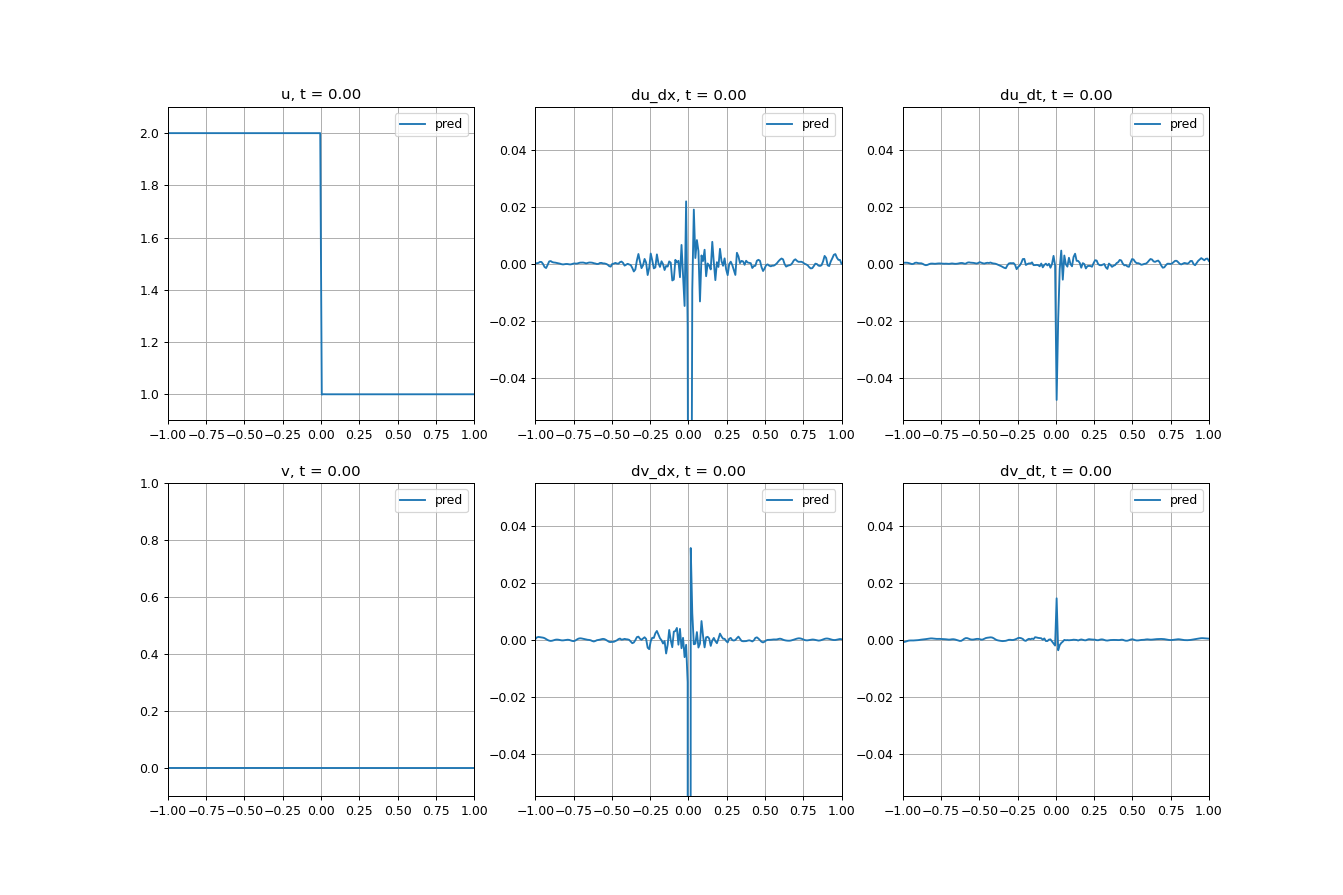

In [10]:
params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 200)
t_test = jnp.linspace(*domain[:, 1], 200)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]
duv_dxt_preds = [jacobian(params_, xt_test) for xt_test in xt_tests]
du_dx_preds, dv_dx_preds = [duv_dxt_pred[:, 0:1, 0] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 0] for duv_dxt_pred in duv_dxt_preds]
du_dt_preds, dv_dt_preds = [duv_dxt_pred[:, 0:1, 1] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 1] for duv_dxt_pred in duv_dxt_preds]

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(2, 3, figsize = (15, 10))
lines = []
for i in range(2):
	for j in range(3):
		line, = ax[i][j].plot([], [], lw = 1.5, label = "pred")
		lines.append(line)
		ax[i][j].set_xlim([-1, 1])
		ax[i][j].legend()
		ax[i][j].grid()
ax[0][0].set_ylim([0.9, 2.1])
ax[1][0].set_ylim([-0.1, 1.0])
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	du_dx_pred, dv_dx_pred = du_dx_preds[i], dv_dx_preds[i]
	du_dt_pred, dv_dt_pred = du_dt_preds[i], dv_dt_preds[i]
# 	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_pred)
	ax[0][0].set_title("u, t = {:.2f}".format(t_test[i]))
	lines[1].set_data(x_test, du_dx_pred)
	ax[0][1].set_title("du_dx, t = {:.2f}".format(t_test[i]))
	lines[2].set_data(x_test, du_dt_pred)
	ax[0][2].set_title("du_dt, t = {:.2f}".format(t_test[i]))
    
	lines[3].set_data(x_test, v_pred)
	ax[1][0].set_title("v, t = {:.2f}".format(t_test[i]))
	lines[4].set_data(x_test, dv_dx_pred)
	ax[1][1].set_title("dv_dx, t = {:.2f}".format(t_test[i]))
	lines[5].set_data(x_test, dv_dt_pred)
	ax[1][2].set_title("dv_dt, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 50, blit = True)
plt.show()

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x_test, u_preds[-1], label = "pred")
ax[0].set_title("u, t = {}".format(t_test[-1]))
ax[1].plot(x_test, v_preds[-1], label = "pred")
ax[1].set_title("v, t = {}".format(t_test[-1]))
for i in range(2):
	ax[i].legend()
	ax[i].grid()
plt.show()

In [ ]:
# x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
# t = jnp.zeros_like(x)
# xt = jnp.hstack([x, t])


# # direct_params_ = direct_params
# direct_params_ = get_params(opt_state)
# duv_dxt = jacobian(direct_params_, xt)
# du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
# du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
# duv_dxxtt = hessian(direct_params_, xt)
# du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
# uv = model(direct_params_, xt)
# u, v = uv[:, 0:1], uv[:, 1:2]
# loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
# loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
# du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
# u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
# du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
# dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
# loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
# loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

# %matplotlib inline
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams["text.usetex"] = True

# f, ax = plt.subplots(2, 5, figsize = (20, 10))
# i, j = 0, 0
# ax[i][j].plot(x, du_dt, label = "pred")
# ax[i][j].plot(x, du0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
# i = 1
# ax[i][j].plot(x, dv_dt, label = "pred")
# ax[i][j].plot(x, dv0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dx, label = "pred")
# ax[i][j].plot(x, du0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
# i = 1
# ax[i][j].plot(x, dv_dx, label = "pred")
# ax[i][j].plot(x, dv0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dxx, label = "pred")
# ax[i][j].plot(x, du0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
# i = 1
# ax[i][j].plot(x, dv_dxx, label = "pred")
# ax[i][j].plot(x, dv0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
# i, j = 0, j+1
# ax[i][j].plot(x, u, label = "pred")
# ax[i][j].plot(x, u0, label = "true")
# ax[i][j].set_title(r"$u$")
# i = 1
# ax[i][j].plot(x, v, label = "pred")
# ax[i][j].plot(x, v0, label = "true")
# ax[i][j].set_title(r"$v$")
# i, j = 0, j+1
# ax[i][j].plot(x, loss_c1, label = "pred")
# ax[i][j].plot(x, loss_c10, label = "true")
# ax[i][j].set_title(r"loss c1")
# i = 1
# ax[i][j].plot(x, loss_c2, label = "pred")
# ax[i][j].plot(x, loss_c20, label = "true")
# ax[i][j].set_title(r"loss c2")

# for i in range(2):
# 	for j in range(5):
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
du0_dx_fn(jnp.array([[-0.25, 0.0], [0.25, 0.0]]))